# Libraries

In [12]:
#Libraries
import gymnasium as gym
from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.envs.tetris import TetrisState
from tetris_gymnasium.wrappers.observation import FeatureVectorObservation

import sys
import cv2
import time
import numpy as np

import os

import neat
import pickle

# Function to Have a Neural Network Play Tetris and Output Fitness

In [15]:
### Define function to have the neural network play Tetris and output the fitness
def eval_nn(i_net):
    '''
    #input the neural network which is dictated 
    '''

    if __name__ == "__main__":
        env = gym.make("tetris_gymnasium/Tetris", render_mode="ansi")
        env.reset()
        
        reward_hist = 0
        del_h_hist = 0
        del_holes_hist = 0 

        terminated = False
        while not terminated:
            ### CODE TO GET THE HEIGHT AFTER EACH FRAME 
            #the board doesn't include the piece (the piece is a projection onto the board)
            env1 = FeatureVectorObservation(env) #create an instance of the class
            
            height_i = env1.calc_height(env.board) #call a function from the class with the board as an input
            height_i = (height_i[4:14])-4 #crop out the padding on either side (the bedrock) and normalize by the 4 layers of bedrock underneath
            prev_height = height_i
            
            ### Code to get the holes after each frame
            holes_i = env1.calc_holes(env.board)
            prev_holes = holes_i
            
            ### FEATURIZE THE TETROMINO
            
            ### Get the current tetromino in a list form and in the position relative to the other blocks
            tetromino = env.active_tetromino
            slices = env.get_tetromino_slices(tetromino, env.x, env.y)
            #Create pseudo_board of just zeros
            only_tetromino = np.zeros((24,18))
            #add the tetromino in its correct place
            only_tetromino[slices] += tetromino.matrix
            #Convert to 1s and 0s
            only_tetromino = np.where(only_tetromino > 0, 1, 0)
            #Sum in each column
            only_tetromino = np.sum(only_tetromino,axis=0)
            #Crop out the empty bedrock
            only_tetromino=only_tetromino[4:14]
            #print(only_tetromino)
            
            #compile the two features together
            i_feat = np.hstack((only_tetromino,height_i)) #this is a one dimensional list of 20 integers

            #Iterate to the next step
            action = np.argmax(i_net.activate(i_feat)) #input is a vector of length 20, and outputs a number 0-3
            if action ==2:
                action = 5
            observation, reward, terminated, truncated, info = env.step(action)
            
            #Running total of the blocks placed
            reward_hist+=reward
            

            #Calculate the change in max height only after a block is placed:
            if reward>0:
                #Calculate the new height and holes of the board
                env1 = FeatureVectorObservation(env) #create an instance of the class
                height_new = env1.calc_height(env.board) #call a function from the class with the board as an input
                height_new = (height_new[4:14])-4
                holes_new = env1.calc_holes(env.board) 
                
                #Find the difference in the height 
                max_h_index = np.argmax(height_new)
                i_del_h = height_new[max_h_index] - prev_height[max_h_index]
                
                #Find the difference in the holes
                i_del_holes = holes_new - prev_holes
                
                #Assign height and holes to previous for the next step 
                prev_height = height_new
                prev_holes = holes_new
                
                #Give positive reward if the height didn't change
                if i_del_h == 0:
                    del_h_hist += 1
                #Give positive reward if the holes didn't change
                if i_del_holes <= 0:
                    del_holes_hist +=1
                    #print(del_holes_hist)

    return float(reward_hist), del_holes_hist, del_h_hist #the cumulative score at the end is the fitness

# Function to Generate and Evaluate Each Generation of Genes

In [16]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0
        net_i = neat.nn.FeedForwardNetwork.create(genome, config)
        reward_i , del_holes_i, del_h_i= eval_nn(net_i)
        genome.fitness = del_h_i + del_holes_i
        
        #If the genome fitness is above 100, save as a pickle file
            # Save the winning_neural_network to a file
        if genome.fitness>100:
            with open(str(genome_id)+'.'+str(reward_i)+'.pkl', 'wb') as f:
                pickle.dump(net_i, f)

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 400)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)


    #node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    draw_net(config, winner, True)
    plot_stats(stats, ylog=False, view=True)
    plot_species(stats, view=True)
    
    
    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)
    return winner_net

# Visualization of Species Fitness Statistics Over the Generations

In [17]:
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot


# Run the NEAT Algorithm Using the Specific Configuration File and Save Winning Neural Network in a Pickle File


 ****** Running generation 0 ****** 

Population's average fitness: 4.10667 stdev: 2.60550
Best fitness: 14.00000 - size: (20, 384) - species 58 - id 58
Average adjusted fitness: 0.239
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     2      2.0    0.077     0
     2    0     2      2.0    0.077     0
     3    0     2      4.0    0.231     0
     4    0     2      5.0    0.308     0
     5    0     2      6.0    0.385     0
     6    0     2      7.0    0.462     0
     7    0     2      3.0    0.154     0
     8    0     2      3.0    0.154     0
     9    0     2     10.0    0.692     0
    10    0     2      3.0    0.154     0
    11    0     2      3.0    0.154     0
    12    0     2      4.0    0.231     0
    13    0     2      2.0    0.077     0
    14    0     2      3.0    0.154     0
    15    0     2      8.0    0.538     0
    

Population's average fitness: 4.06667 stdev: 2.91014
Best fitness: 19.00000 - size: (19, 356) - species 120 - id 158
Average adjusted fitness: 0.214
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    2     2      9.0    0.263     0
     2    2     2      3.0    0.105     0
     3    2     2      3.0    0.132     2
     4    2     2      4.0    0.158     1
     5    2     2      9.0    0.421     1
     6    2     2      8.0    0.289     0
     7    2     2      2.0    0.105     2
     8    2     2      8.0    0.316     0
     9    2     2      5.0    0.184     2
    10    2     2      1.0    0.053     2
    11    2     2      4.0    0.105     0
    12    2     2      9.0    0.368     0
    13    2     2      2.0    0.079     1
    14    2     2      2.0    0.079     2
    15    2     2      5.0    0.237     2
    16    2     2      3.0    0.105     1

Population's average fitness: 4.37000 stdev: 2.99996
Best fitness: 15.00000 - size: (20, 384) - species 107 - id 107
Average adjusted fitness: 0.291
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4     2      7.0    0.300     2
     2    4     2      4.0    0.233     0
     3    4     2      4.0    0.233     4
     4    4     2      3.0    0.133     3
     5    4     2     11.0    0.500     0
     6    4     2      6.0    0.300     2
     7    4     2      2.0    0.067     4
     8    4     2      6.0    0.333     2
     9    4     2      7.0    0.400     4
    10    4     2      3.0    0.133     1
    11    4     2      3.0    0.100     1
    12    4     2     10.0    0.500     0
    13    4     2      4.0    0.167     3
    14    4     2      5.0    0.267     1
    15    4     2      6.0    0.367     4
    16    4     2      4.0    0.167     3

Population's average fitness: 4.12000 stdev: 2.92215
Best fitness: 17.00000 - size: (20, 383) - species 95 - id 216
Average adjusted fitness: 0.242
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    6     2      8.0    0.265     4
     2    6     2      2.0    0.118     2
     3    6     2      4.0    0.147     6
     4    6     2      2.0    0.088     1
     5    6     2      7.0    0.324     2
     6    6     2      5.0    0.265     4
     7    6     2      3.0    0.147     6
     8    6     2      8.0    0.441     1
     9    6     2      4.0    0.206     6
    10    6     2      3.0    0.118     3
    11    6     2      4.0    0.206     1
    12    6     2      8.0    0.441     2
    13    6     2      1.0    0.059     5
    14    6     2      5.0    0.294     3
    15    6     2      2.0    0.088     6
    16    6     2      3.0    0.147     5


Population's average fitness: 4.44333 stdev: 3.05616
Best fitness: 19.00000 - size: (20, 381) - species 26 - id 276
Average adjusted fitness: 0.234
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    8     2      4.0    0.158     6
     2    8     2      2.0    0.105     1
     3    8     2      4.0    0.158     1
     4    8     2      4.0    0.158     3
     5    8     2      8.0    0.421     4
     6    8     2      3.0    0.132     6
     7    8     2      3.0    0.132     8
     8    8     2      8.0    0.368     3
     9    8     2      5.0    0.237     8
    10    8     2      6.0    0.263     1
    11    8     2      5.0    0.237     3
    12    8     2      9.0    0.421     1
    13    8     2      3.0    0.132     7
    14    8     2      4.0    0.184     1
    15    8     2      6.0    0.316     8
    16    8     2      2.0    0.053     7



 ****** Running generation 10 ****** 

Population's average fitness: 4.26333 stdev: 2.91216
Best fitness: 18.00000 - size: (20, 384) - species 48 - id 48
Average adjusted fitness: 0.237
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   10     2      7.0    0.222     8
     2   10     2      2.0    0.111     3
     3   10     2      4.0    0.194     3
     4   10     2      3.0    0.139     5
     5   10     2      5.0    0.167     6
     6   10     2      3.0    0.139     8
     7   10     2      3.0    0.167    10
     8   10     2      4.0    0.222     5
     9   10     2      4.0    0.167    10
    10   10     2      4.0    0.167     3
    11   10     2      3.0    0.167     5
    12   10     2     11.0    0.583     3
    13   10     2      4.0    0.194     9
    14   10     2      4.0    0.139     3
    15   10     2      4.0    0.194    10
   

Population's average fitness: 4.27667 stdev: 3.00113
Best fitness: 16.00000 - size: (20, 384) - species 58 - id 58
Average adjusted fitness: 0.267
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   12     2      6.0    0.219    10
     2   12     2      4.0    0.188     5
     3   12     2      5.0    0.219     5
     4   12     2      6.0    0.281     7
     5   12     2     10.0    0.562     8
     6   12     2      6.0    0.344    10
     7   12     2      5.0    0.219     0
     8   12     2      6.0    0.312     7
     9   12     2      8.0    0.469    12
    10   12     2      3.0    0.156     5
    11   12     2      6.0    0.219     7
    12   12     2      9.0    0.469     1
    13   12     2      4.0    0.156    11
    14   12     2      3.0    0.156     5
    15   12     2      4.0    0.250    12
    16   12     2      2.0    0.062    11
 

Population's average fitness: 4.35333 stdev: 2.84988
Best fitness: 18.00000 - size: (20, 384) - species 58 - id 58
Average adjusted fitness: 0.242
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14     2      7.0    0.250    12
     2   14     2      2.0    0.111     7
     3   14     2      3.0    0.139     7
     4   14     2      4.0    0.167     9
     5   14     2      6.0    0.306    10
     6   14     2      6.0    0.333    12
     7   14     2      4.0    0.194     2
     8   14     2      5.0    0.222     9
     9   14     2      5.0    0.250    14
    10   14     2      4.0    0.139     7
    11   14     2      5.0    0.167     9
    12   14     2      7.0    0.306     3
    13   14     2      3.0    0.167    13
    14   14     2      3.0    0.167     7
    15   14     2      6.0    0.333    14
    16   14     2      5.0    0.250    13
 

Population's average fitness: 4.19333 stdev: 2.92278
Best fitness: 17.00000 - size: (19, 359) - species 24 - id 293
Average adjusted fitness: 0.247
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16     2      8.0    0.294    14
     2   16     2      3.0    0.147     9
     3   16     2      3.0    0.176     9
     4   16     2      7.0    0.235     1
     5   16     2      7.0    0.324    12
     6   16     2      4.0    0.235    14
     7   16     2      2.0    0.118     4
     8   16     2      4.0    0.206    11
     9   16     2      4.0    0.206    16
    10   16     2      7.0    0.294     9
    11   16     2      3.0    0.147    11
    12   16     2      8.0    0.412     5
    13   16     2      3.0    0.147    15
    14   16     2      4.0    0.206     9
    15   16     2      4.0    0.235    16
    16   16     2      3.0    0.118    15


Population's average fitness: 4.12333 stdev: 2.60540
Best fitness: 15.00000 - size: (20, 381) - species 90 - id 286
Average adjusted fitness: 0.275
Mean genetic distance 3.677, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18     2      5.0    0.267    16
     2   18     2      2.0    0.100    11
     3   18     2      3.0    0.200    11
     4   18     2      4.0    0.167     3
     5   18     2      6.0    0.367    14
     6   18     2      4.0    0.267    16
     7   18     2      2.0    0.133     6
     8   18     2      4.0    0.200    13
     9   18     2      7.0    0.300    18
    10   18     2      5.0    0.233    11
    11   18     2      3.0    0.200    13
    12   18     2      6.0    0.367     7
    13   18     2      3.0    0.167    17
    14   18     2      5.0    0.200    11
    15   18     2      4.0    0.233    18
    16   18     2      2.0    0.133    17



 ****** Running generation 20 ****** 

Population's average fitness: 4.30667 stdev: 2.95059
Best fitness: 17.00000 - size: (21, 380) - species 91 - id 299

Species 88 with 2 members is stagnated: removing it

Species 83 with 2 members is stagnated: removing it

Species 121 with 2 members is stagnated: removing it

Species 99 with 2 members is stagnated: removing it

Species 75 with 2 members is stagnated: removing it

Species 15 with 2 members is stagnated: removing it

Species 9 with 2 members is stagnated: removing it
Average adjusted fitness: 0.256
Mean genetic distance 3.677, standard deviation 0.291
Population of 286 members in 143 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   20     2      6.0    0.235    18
     2   20     2      3.0    0.147    13
     3   20     2      3.0    0.147    13
     4   20     2      3.0    0.147     5
     5   20     2      9.0    0.441    16
     6   20     2      5.0    0.265    18
     7   

Population's average fitness: 4.36567 stdev: 2.97512
Best fitness: 14.00000 - size: (20, 381) - species 139 - id 257

Species 146 with 2 members is stagnated: removing it

Species 41 with 2 members is stagnated: removing it

Species 50 with 2 members is stagnated: removing it

Species 22 with 2 members is stagnated: removing it

Species 19 with 2 members is stagnated: removing it

Species 127 with 2 members is stagnated: removing it

Species 6 with 2 members is stagnated: removing it

Species 78 with 2 members is stagnated: removing it

Species 150 with 2 members is stagnated: removing it

Species 120 with 2 members is stagnated: removing it

Species 28 with 2 members is stagnated: removing it
Average adjusted fitness: 0.317
Mean genetic distance 3.675, standard deviation 0.312
Population of 246 members in 123 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   22     2     10.0    0.500     0
     2   22     2      4.0    0.214    15
 

Population's average fitness: 4.18803 stdev: 2.83275
Best fitness: 15.00000 - size: (20, 384) - species 101 - id 101

Species 133 with 2 members is stagnated: removing it

Species 81 with 2 members is stagnated: removing it

Species 29 with 2 members is stagnated: removing it

Species 72 with 2 members is stagnated: removing it

Species 63 with 2 members is stagnated: removing it

Species 108 with 2 members is stagnated: removing it

Species 122 with 2 members is stagnated: removing it

Species 107 with 2 members is stagnated: removing it

Species 74 with 2 members is stagnated: removing it

Species 110 with 2 members is stagnated: removing it

Species 104 with 2 members is stagnated: removing it
Average adjusted fitness: 0.285
Mean genetic distance 3.670, standard deviation 0.336
Population of 212 members in 106 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   24     2      3.0    0.167     2
     2   24     2      3.0    0.167    1

Population's average fitness: 4.40796 stdev: 3.28766
Best fitness: 14.00000 - size: (20, 384) - species 42 - id 42

Species 47 with 2 members is stagnated: removing it

Species 61 with 2 members is stagnated: removing it

Species 54 with 2 members is stagnated: removing it

Species 118 with 2 members is stagnated: removing it

Species 53 with 2 members is stagnated: removing it

Species 116 with 2 members is stagnated: removing it

Species 95 with 2 members is stagnated: removing it
Average adjusted fitness: 0.318
Mean genetic distance 3.664, standard deviation 0.357
Population of 187 members in 93 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   26     2      5.0    0.250     4
     2   26     2      3.0    0.179    19
     3   26     2      3.0    0.143    19
     4   26     2      4.0    0.143    11
     5   26     2      4.0    0.179     5
     7   26     2      1.0    0.036     1
     8   26     2      6.0    0.286     7
    10 

Population's average fitness: 4.30120 stdev: 3.07040
Best fitness: 15.00000 - size: (20, 384) - species 87 - id 87

Species 31 with 2 members is stagnated: removing it
Average adjusted fitness: 0.284
Mean genetic distance 3.661, standard deviation 0.382
Population of 164 members in 81 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   28     2      3.0    0.167     6
     4   28     2      4.0    0.200    13
     5   28     2      8.0    0.400     7
     7   28     2      3.0    0.167     3
     8   28     2      7.0    0.267     9
    12   28     2      9.0    0.333    17
    18   28     2      4.0    0.200    10
    21   28     2     11.0    0.400     6
    23   28     2      4.0    0.167    16
    24   28     2      4.0    0.200     1
    26   28     2      7.0    0.467     7
    27   28     2      6.0    0.233    16
    30   28     2      4.0    0.233     7
    34   28     2      3.0    0.167     5
    35   28     2      3.0    0.2

Population's average fitness: 4.67114 stdev: 3.72267
Best fitness: 23.00000 - size: (20, 381) - species 26 - id 276

Species 40 with 2 members is stagnated: removing it

Species 82 with 2 members is stagnated: removing it

Species 49 with 2 members is stagnated: removing it

Species 12 with 2 members is stagnated: removing it

Species 148 with 2 members is stagnated: removing it
Average adjusted fitness: 0.200
Mean genetic distance 3.646, standard deviation 0.405
Population of 168 members in 69 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31     3      8.0    0.261     1
     4   31     2      4.0    0.130    16
     5   31     3      7.0    0.304    10
     7   31     2      3.0    0.109     6
     8   31     3     12.0    0.370    12
    18   31     2      3.0    0.109    13
    21   31     2      3.0    0.109     9
    23   31     3      6.0    0.217    19
    24   31     3     12.0    0.478     4
    26   31     3     23.0   

Population's average fitness: 5.02410 stdev: 3.27265
Best fitness: 15.00000 - size: (22, 381) - species 5 - id 398

Species 62 with 2 members is stagnated: removing it

Species 60 with 2 members is stagnated: removing it

Species 93 with 2 members is stagnated: removing it

Species 117 with 2 members is stagnated: removing it

Species 102 with 5 members is stagnated: removing it

Species 58 with 5 members is stagnated: removing it
Average adjusted fitness: 0.308
Mean genetic distance 3.607, standard deviation 0.447
Population of 162 members in 53 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34     4     11.0    0.356     4
     4   34     5     12.0    0.517     0
     5   34     5     15.0    0.467     0
     7   34     3      4.0    0.233     9
     8   34     4      8.0    0.400    15
    18   34     2      2.0    0.133    16
    21   34     4      8.0    0.333    12
    24   34     4     11.0    0.440     7
    26   34     5 

Population's average fitness: 5.64815 stdev: 3.84173
Best fitness: 23.00000 - size: (19, 359) - species 67 - id 430

Species 138 with 3 members is stagnated: removing it
Average adjusted fitness: 0.192
Mean genetic distance 3.597, standard deviation 0.464
Population of 157 members in 49 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37     4     11.0    0.386     7
     4   37     4      9.0    0.242     3
     5   37     5     14.0    0.439     3
     7   37     2      2.0    0.023    12
     8   37     3     11.0    0.239    18
    18   37     3      6.0    0.148     1
    21   37     3      8.0    0.205    15
    24   37     3      8.0    0.227    10
    26   37     4      9.0    0.303     6
    30   37     2      3.0    0.091    16
    34   37     2      2.0    0.023    14
    35   37     2      3.0    0.045    10
    38   37     2      2.0    0.045    16
    43   37     3      5.0    0.102     2
    55   37     3      8.0    0

Population's average fitness: 6.05263 stdev: 3.82132
Best fitness: 18.00000 - size: (19, 356) - species 67 - id 717

Species 38 with 2 members is stagnated: removing it
Average adjusted fitness: 0.319
Mean genetic distance 3.553, standard deviation 0.498
Population of 154 members in 39 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   41     2      8.0    0.241    11
     4   41     4     10.0    0.481     7
     5   41     3      5.0    0.222     7
     7   41     3      3.0    0.167    16
    18   41     3      6.0    0.250     5
    21   41     5     10.0    0.389     2
    24   41     5     13.0    0.403    14
    26   41     4      9.0    0.356    10
    30   41     4      8.0    0.278     0
    34   41     2     11.0    0.241     0
    35   41     4     11.0    0.417     0
    43   41     4     11.0    0.244     6
    55   41     3      3.0    0.111    17
    67   41     5     18.0    0.463     4
    69   41     2      5.0    0.

Population's average fitness: 6.82877 stdev: 3.95931
Best fitness: 17.00000 - size: (21, 379) - species 24 - id 734

Species 7 with 2 members is stagnated: removing it

Species 100 with 3 members is stagnated: removing it

Species 115 with 4 members is stagnated: removing it

Species 84 with 5 members is stagnated: removing it
Average adjusted fitness: 0.387
Mean genetic distance 3.516, standard deviation 0.549
Population of 153 members in 31 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   45     6     12.0    0.412     1
     4   45     7     14.0    0.459     0
     5   45     3      8.0    0.353    11
    18   45     3      8.0    0.265     9
    21   45     6     14.0    0.461     6
    24   45     7     17.0    0.588    18
    26   45     7     10.0    0.447    14
    30   45     2      5.0    0.235     4
    34   45     4      8.0    0.294     4
    35   45     2      4.0    0.118     4
    43   45     7     14.0    0.600     

Population's average fitness: 7.32192 stdev: 4.25060
Best fitness: 18.00000 - size: (19, 323) - species 124 - id 1125
Average adjusted fitness: 0.349
Mean genetic distance 3.509, standard deviation 0.571
Population of 147 members in 28 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   50     5     11.0    0.333     2
     4   50     5      8.0    0.216     5
     5   50     4     11.0    0.235    16
    18   50     2      4.0    0.118     2
    21   50     5     11.0    0.294    11
    26   50     6     17.0    0.454    19
    30   50     4     14.0    0.224     0
    34   50     4     15.0    0.314     0
    35   50     2      3.0    0.088     9
    43   50     6     15.0    0.447     7
    55   50     5     13.0    0.382     6
    67   50     6     17.0    0.388    13
    69   50     2      3.0    0.088    15
    70   50     4     11.0    0.353     7
    71   50     5     11.0    0.373    11
    79   50     7     13.0    0.431    15

Population's average fitness: 7.14865 stdev: 4.14332
Best fitness: 21.00000 - size: (21, 353) - species 70 - id 1984
Average adjusted fitness: 0.292
Mean genetic distance 3.513, standard deviation 0.605
Population of 150 members in 23 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   56     5     14.0    0.250     2
     4   56     5     10.0    0.267     3
    18   56     4      5.0    0.167     8
    21   56     8     12.0    0.336    17
    30   56     5     11.0    0.258     6
    34   56     7     13.0    0.390     6
    35   56     2      3.0    0.075    15
    43   56     5      6.0    0.200    13
    55   56     7     12.0    0.312     1
    67   56     8     18.0    0.389    19
    70   56     6     21.0    0.270     0
    71   56     7     11.0    0.275    17
    79   56     9     15.0    0.375     5
    86   56     8     11.0    0.322     3
    87   56     6     11.0    0.214    13
   101   56     9     18.0    0.529     7


Population's average fitness: 7.04000 stdev: 4.13744
Best fitness: 20.00000 - size: (19, 310) - species 79 - id 2792
Average adjusted fitness: 0.311
Mean genetic distance 3.481, standard deviation 0.660
Population of 148 members in 20 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   62     6     15.0    0.295     8
     4   62     6     11.0    0.241     9
    18   62     6     11.0    0.263    14
    21   62     7     17.0    0.322     1
    30   62     7     11.0    0.243    12
    34   62    11     17.0    0.453     2
    43   62     6      8.0    0.232    19
    55   62     8     15.0    0.339     7
    70   62     6     10.0    0.271     6
    79   62    11     20.0    0.586     5
    86   62     8     12.0    0.331     9
    87   62     7     15.0    0.309    19
   101   62     7     10.0    0.224    13
   106   62     8     11.0    0.263     7
   124   62     7     12.0    0.307    14
   134   62     7     14.0    0.322     4


Population's average fitness: 7.73793 stdev: 4.48603
Best fitness: 19.00000 - size: (23, 325) - species 70 - id 3157

Species 101 with 8 members is stagnated: removing it
Average adjusted fitness: 0.398
Mean genetic distance 3.430, standard deviation 0.705
Population of 144 members in 16 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   69    10     12.0    0.439    15
     4   69     9     16.0    0.454    16
    18   69     8     15.0    0.383     0
    21   69     6     17.0    0.226     8
    30   69     9     16.0    0.434     0
    34   69    10     15.0    0.373     3
    55   69    10     16.0    0.368     4
    70   69    11     19.0    0.447    13
    79   69    10     17.0    0.485     2
    86   69     7     18.0    0.276    16
   106   69     9     15.0    0.428    14
   134   69    10     14.0    0.433    11
   135   69     7      9.0    0.316    15
   137   69    10     14.0    0.503    14
   139   69     9     14.0    

Population's average fitness: 7.39735 stdev: 4.63514
Best fitness: 21.00000 - size: (20, 300) - species 34 - id 4548
Average adjusted fitness: 0.340
Mean genetic distance 3.298, standard deviation 0.831
Population of 149 members in 9 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   77    16     15.0    0.291     7
    18   77    11      9.0    0.206     5
    21   77    12     14.0    0.245     5
    30   77    14     14.0    0.305     8
    34   77    22     21.0    0.493    11
    55   77    20     20.0    0.404     5
    79   77    18     18.0    0.368    10
   134   77    18     15.0    0.370    19
   139   77    18     12.0    0.378    14
Total extinctions: 0
Generation time: 21.764 sec (21.005 average)

 ****** Running generation 78 ****** 

Population's average fitness: 7.46980 stdev: 4.54295
Best fitness: 21.00000 - size: (18, 281) - species 4 - id 4623
Average adjusted fitness: 0.351
Mean genetic distance 3.298, standard dev

Population's average fitness: 7.21333 stdev: 4.15786
Best fitness: 19.00000 - size: (17, 250) - species 79 - id 5981
Average adjusted fitness: 0.379
Mean genetic distance 3.192, standard deviation 0.811
Population of 151 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   88    24     17.0    0.430    10
    18   88    20     15.0    0.331    16
    21   88    22     18.0    0.416     8
    30   88    22     14.0    0.398    19
    55   88    24     15.0    0.368     3
    79   88    19     19.0    0.363     3
   139   88    20     13.0    0.346     6
Total extinctions: 0
Generation time: 19.739 sec (20.085 average)

 ****** Running generation 89 ****** 

Population's average fitness: 7.30464 stdev: 4.46768
Best fitness: 21.00000 - size: (22, 237) - species 55 - id 6107

Species 30 with 22 members is stagnated: removing it
Average adjusted fitness: 0.346
Mean genetic distance 3.112, standard deviation 0.865
Population of 15

Population's average fitness: 7.70000 stdev: 4.79131
Best fitness: 21.00000 - size: (21, 219) - species 55 - id 7676

Species 21 with 29 members is stagnated: removing it
Average adjusted fitness: 0.359
Mean genetic distance 2.824, standard deviation 0.878
Population of 150 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  100    31     15.0    0.263     8
    55  100    47     21.0    0.452    15
    79  100    34     19.0    0.350    15
   139  100    38     17.0    0.371    18
Total extinctions: 0
Generation time: 20.029 sec (19.237 average)

 ****** Running generation 101 ****** 

Population's average fitness: 7.06667 stdev: 4.21057
Best fitness: 21.00000 - size: (21, 206) - species 55 - id 7823
Average adjusted fitness: 0.299
Mean genetic distance 2.799, standard deviation 0.871
Population of 150 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  101    30

Population's average fitness: 7.45333 stdev: 4.63406
Best fitness: 20.00000 - size: (26, 213) - species 55 - id 9852
Average adjusted fitness: 0.335
Mean genetic distance 2.580, standard deviation 0.711
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  115    67     15.0    0.299     3
    55  115    83     20.0    0.372     2
Total extinctions: 0
Generation time: 19.580 sec (19.477 average)

 ****** Running generation 116 ****** 

Population's average fitness: 7.66667 stdev: 4.80925
Best fitness: 21.00000 - size: (23, 204) - species 55 - id 10009
Average adjusted fitness: 0.364
Mean genetic distance 2.565, standard deviation 0.755
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  116    70     19.0    0.351     4
    55  116    80     21.0    0.376     3
Total extinctions: 0
Generation time: 19.429 sec (19.526 average)

 **

Population's average fitness: 7.59333 stdev: 4.89775
Best fitness: 19.00000 - size: (24, 171) - species 55 - id 12180
Average adjusted fitness: 0.358
Mean genetic distance 2.664, standard deviation 0.851
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  131    63     18.0    0.290    19
    55  131    87     19.0    0.426     7
Total extinctions: 0
Generation time: 17.574 sec (18.163 average)

 ****** Running generation 132 ****** 

Population's average fitness: 6.77333 stdev: 4.29130
Best fitness: 19.00000 - size: (24, 167) - species 55 - id 12325
Average adjusted fitness: 0.315
Mean genetic distance 2.661, standard deviation 0.933
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  132    64     16.0    0.276    20
    55  132    86     19.0    0.353     8
Total extinctions: 0
Generation time: 16.505 sec (17.826 average)

 *

Population's average fitness: 8.75333 stdev: 4.85240
Best fitness: 20.00000 - size: (24, 141) - species 18 - id 14269
Average adjusted fitness: 0.437
Mean genetic distance 2.709, standard deviation 0.946
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  147    73     20.0    0.428    35
    55  147    77     20.0    0.447    23
Total extinctions: 0
Generation time: 18.020 sec (17.441 average)

 ****** Running generation 148 ****** 

Population's average fitness: 8.00667 stdev: 4.58766
Best fitness: 18.00000 - size: (19, 129) - species 18 - id 14607
Average adjusted fitness: 0.412
Mean genetic distance 2.648, standard deviation 1.024
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  148    72     18.0    0.400    36
    55  148    78     17.0    0.424    24
Total extinctions: 0
Generation time: 17.753 sec (17.463 average)

 *

Population's average fitness: 8.29333 stdev: 5.09058
Best fitness: 20.00000 - size: (26, 120) - species 55 - id 16878
Average adjusted fitness: 0.411
Mean genetic distance 2.704, standard deviation 0.892
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  163    67     18.0    0.344    51
    55  163    83     20.0    0.478    39
Total extinctions: 0
Generation time: 16.443 sec (16.656 average)

 ****** Running generation 164 ****** 

Population's average fitness: 8.34000 stdev: 5.30639
Best fitness: 22.00000 - size: (26, 100) - species 55 - id 17010
Average adjusted fitness: 0.349
Mean genetic distance 2.719, standard deviation 0.867
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  164    71     20.0    0.345    52
    55  164    79     22.0    0.353    40
Total extinctions: 0
Generation time: 16.163 sec (16.613 average)
Sav

Population's average fitness: 8.87333 stdev: 5.35699
Best fitness: 21.00000 - size: (23, 107) - species 18 - id 18929
Average adjusted fitness: 0.393
Mean genetic distance 2.691, standard deviation 0.986
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  179    71     21.0    0.359    67
    55  179    79     20.0    0.427    55
Total extinctions: 0
Generation time: 16.410 sec (16.427 average)
Saving checkpoint to neat-checkpoint-179

 ****** Running generation 180 ****** 

Population's average fitness: 8.66000 stdev: 5.48067
Best fitness: 22.00000 - size: (26, 111) - species 18 - id 19356
Average adjusted fitness: 0.363
Mean genetic distance 2.673, standard deviation 1.017
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  180    70     22.0    0.331    68
    55  180    80     21.0    0.395    56
Total extinctions: 0
Generat


 ****** Running generation 195 ****** 

Population's average fitness: 8.56000 stdev: 5.76597
Best fitness: 26.00000 - size: (30, 95) - species 55 - id 21495
Average adjusted fitness: 0.302
Mean genetic distance 2.846, standard deviation 0.875
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  195    77     23.0    0.317    83
    55  195    73     26.0    0.288    71
Total extinctions: 0
Generation time: 15.049 sec (15.763 average)

 ****** Running generation 196 ****** 

Population's average fitness: 8.80667 stdev: 4.94597
Best fitness: 22.00000 - size: (26, 91) - species 55 - id 21687
Average adjusted fitness: 0.372
Mean genetic distance 2.850, standard deviation 0.833
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  196    74     20.0    0.353    84
    55  196    76     22.0    0.391    72
Total extinctions: 0
Generatio

Population's average fitness: 8.07333 stdev: 5.06109
Best fitness: 21.00000 - size: (27, 80) - species 18 - id 23809
Average adjusted fitness: 0.383
Mean genetic distance 2.929, standard deviation 0.844
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  211    69     21.0    0.354     6
    55  211    81     20.0    0.411    87
Total extinctions: 0
Generation time: 14.546 sec (14.954 average)

 ****** Running generation 212 ****** 

Population's average fitness: 8.16000 stdev: 5.42473
Best fitness: 23.00000 - size: (29, 107) - species 55 - id 23875
Average adjusted fitness: 0.353
Mean genetic distance 2.782, standard deviation 0.927
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  212    70     20.0    0.325     7
    55  212    80     23.0    0.380    88
Total extinctions: 0
Generation time: 14.478 sec (14.901 average)

 **

Population's average fitness: 7.97333 stdev: 5.25731
Best fitness: 22.00000 - size: (28, 76) - species 151 - id 26130
Average adjusted fitness: 0.362
Mean genetic distance 2.831, standard deviation 0.952
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  227    71     20.0    0.344    22
   151    7    79     22.0    0.379     4
Total extinctions: 0
Generation time: 13.746 sec (14.611 average)

 ****** Running generation 228 ****** 

Population's average fitness: 8.77333 stdev: 5.25503
Best fitness: 19.00000 - size: (25, 68) - species 18 - id 26223
Average adjusted fitness: 0.431
Mean genetic distance 2.811, standard deviation 0.939
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  228    72     19.0    0.415    23
   151    8    78     19.0    0.447     5
Total extinctions: 0
Generation time: 14.102 sec (14.588 average)

 **

Population's average fitness: 9.56000 stdev: 5.36343
Best fitness: 25.00000 - size: (26, 62) - species 18 - id 28267
Average adjusted fitness: 0.381
Mean genetic distance 2.747, standard deviation 0.954
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  243    70     25.0    0.369     0
   151   23    80     24.0    0.394     9
Total extinctions: 0
Generation time: 14.699 sec (14.433 average)

 ****** Running generation 244 ****** 

Population's average fitness: 9.32667 stdev: 5.55037
Best fitness: 24.00000 - size: (30, 74) - species 151 - id 28618
Average adjusted fitness: 0.387
Mean genetic distance 2.734, standard deviation 0.891
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  244    71     21.0    0.363     1
   151   24    79     24.0    0.411    10
Total extinctions: 0
Generation time: 14.182 sec (14.430 average)
Savi

Population's average fitness: 9.96000 stdev: 5.50137
Best fitness: 23.00000 - size: (27, 51) - species 18 - id 30779
Average adjusted fitness: 0.431
Mean genetic distance 2.589, standard deviation 0.836
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  259    70     23.0    0.404    16
   151   39    80     23.0    0.458    25
Total extinctions: 0
Generation time: 14.845 sec (14.274 average)
Saving checkpoint to neat-checkpoint-259

 ****** Running generation 260 ****** 

Population's average fitness: 8.94667 stdev: 5.26977
Best fitness: 23.00000 - size: (32, 72) - species 151 - id 31029
Average adjusted fitness: 0.386
Mean genetic distance 2.538, standard deviation 0.819
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    18  260    68     18.0    0.339    17
   151   40    82     23.0    0.433    26
Total extinctions: 0
Generati

Population's average fitness: 10.10000 stdev: 5.55428
Best fitness: 23.00000 - size: (33, 71) - species 151 - id 32993
Average adjusted fitness: 0.412
Mean genetic distance 2.472, standard deviation 0.775
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151   54    80     23.0    0.432    40
   152    8    70     18.0    0.392     2
Total extinctions: 0
Generation time: 14.506 sec (14.029 average)
Saving checkpoint to neat-checkpoint-274

 ****** Running generation 275 ****** 

Population's average fitness: 9.21333 stdev: 5.40319
Best fitness: 21.00000 - size: (37, 77) - species 151 - id 33174
Average adjusted fitness: 0.436
Mean genetic distance 2.485, standard deviation 0.759
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151   55    81     21.0    0.481    41
   152    9    69     19.0    0.390     3
Total extinctions: 0
Genera


 ****** Running generation 290 ****** 

Population's average fitness: 9.36000 stdev: 5.64421
Best fitness: 24.00000 - size: (34, 69) - species 151 - id 35386
Average adjusted fitness: 0.389
Mean genetic distance 2.478, standard deviation 0.661
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151   70    78     24.0    0.401    56
   152   24    72     19.0    0.377    10
Total extinctions: 0
Generation time: 13.884 sec (13.545 average)

 ****** Running generation 291 ****** 

Population's average fitness: 9.35333 stdev: 5.39770
Best fitness: 21.00000 - size: (35, 77) - species 151 - id 35531
Average adjusted fitness: 0.416
Mean genetic distance 2.471, standard deviation 0.699
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151   71    80     21.0    0.453    57
   152   25    70     19.0    0.379    11
Total extinctions: 0
Generat

Population's average fitness: 9.20667 stdev: 5.61224
Best fitness: 25.00000 - size: (32, 58) - species 151 - id 37668
Average adjusted fitness: 0.359
Mean genetic distance 2.514, standard deviation 0.963
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151   86    87     25.0    0.425     3
   152   40    63     18.0    0.294     5
Total extinctions: 0
Generation time: 13.465 sec (13.534 average)

 ****** Running generation 307 ****** 

Population's average fitness: 9.38667 stdev: 5.64953
Best fitness: 26.00000 - size: (31, 51) - species 151 - id 37855
Average adjusted fitness: 0.348
Mean genetic distance 2.629, standard deviation 0.910
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151   87    90     26.0    0.427     4
   152   41    60     19.0    0.269     6
Total extinctions: 0
Generation time: 13.623 sec (13.562 average)

 *

Population's average fitness: 9.32000 stdev: 6.26240
Best fitness: 25.00000 - size: (30, 57) - species 151 - id 39929
Average adjusted fitness: 0.371
Mean genetic distance 2.695, standard deviation 0.813
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  102    82     25.0    0.426    19
   152   56    68     19.0    0.317    21
Total extinctions: 0
Generation time: 13.197 sec (13.820 average)

 ****** Running generation 323 ****** 

Population's average fitness: 9.34667 stdev: 5.68857
Best fitness: 26.00000 - size: (33, 52) - species 151 - id 40216
Average adjusted fitness: 0.332
Mean genetic distance 2.696, standard deviation 0.844
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  103    80     26.0    0.348    20
   152   57    70     20.0    0.316    22
Total extinctions: 0
Generation time: 13.416 sec (13.749 average)

 *

Population's average fitness: 8.37333 stdev: 5.48154
Best fitness: 22.00000 - size: (27, 49) - species 152 - id 42324
Average adjusted fitness: 0.376
Mean genetic distance 2.738, standard deviation 0.959
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  118    84     21.0    0.422    35
   152   72    66     22.0    0.329    37
Total extinctions: 0
Generation time: 12.555 sec (13.206 average)

 ****** Running generation 339 ****** 

Population's average fitness: 9.04000 stdev: 5.58675
Best fitness: 20.00000 - size: (24, 43) - species 151 - id 42425
Average adjusted fitness: 0.443
Mean genetic distance 2.750, standard deviation 0.965
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  119    86     20.0    0.518    36
   152   73    64     20.0    0.368    38
Total extinctions: 0
Generation time: 13.137 sec (13.156 average)
Sav

Population's average fitness: 9.52667 stdev: 5.79505
Best fitness: 21.00000 - size: (20, 35) - species 151 - id 44669
Average adjusted fitness: 0.415
Mean genetic distance 2.838, standard deviation 0.783
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  134    87     21.0    0.481    51
   152   88    63     18.0    0.348    53
Total extinctions: 0
Generation time: 13.518 sec (13.200 average)
Saving checkpoint to neat-checkpoint-354

 ****** Running generation 355 ****** 

Population's average fitness: 8.08667 stdev: 5.76303
Best fitness: 24.00000 - size: (27, 45) - species 151 - id 44834
Average adjusted fitness: 0.332
Mean genetic distance 2.799, standard deviation 0.892
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  135    84     24.0    0.361    52
   152   89    66     22.0    0.304    54
Total extinctions: 0
Generat


 ****** Running generation 370 ****** 

Population's average fitness: 9.50667 stdev: 5.76628
Best fitness: 22.00000 - size: (20, 31) - species 151 - id 47038
Average adjusted fitness: 0.400
Mean genetic distance 2.724, standard deviation 0.789
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  150    83     22.0    0.443    67
   152  104    67     19.0    0.357    69
Total extinctions: 0
Generation time: 13.182 sec (13.108 average)

 ****** Running generation 371 ****** 

Population's average fitness: 9.36667 stdev: 5.37081
Best fitness: 22.00000 - size: (26, 39) - species 152 - id 47096
Average adjusted fitness: 0.391
Mean genetic distance 2.646, standard deviation 0.857
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  151    86     21.0    0.460    68
   152  105    64     22.0    0.322    70
Total extinctions: 0
Generat

Population's average fitness: 9.30000 stdev: 5.24309
Best fitness: 21.00000 - size: (19, 35) - species 151 - id 49345
Average adjusted fitness: 0.414
Mean genetic distance 2.777, standard deviation 0.710
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  166    79     21.0    0.428    83
   153   13    71     17.0    0.400     4
Total extinctions: 0
Generation time: 12.793 sec (12.614 average)

 ****** Running generation 387 ****** 

Population's average fitness: 10.04000 stdev: 5.21265
Best fitness: 20.00000 - size: (28, 37) - species 153 - id 49432
Average adjusted fitness: 0.475
Mean genetic distance 2.795, standard deviation 0.796
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  167    78     20.0    0.482    84
   153   14    72     20.0    0.468     5
Total extinctions: 0
Generation time: 13.290 sec (12.634 average)

 

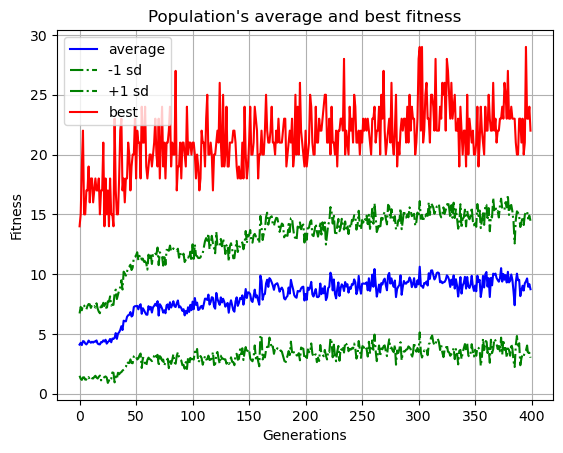

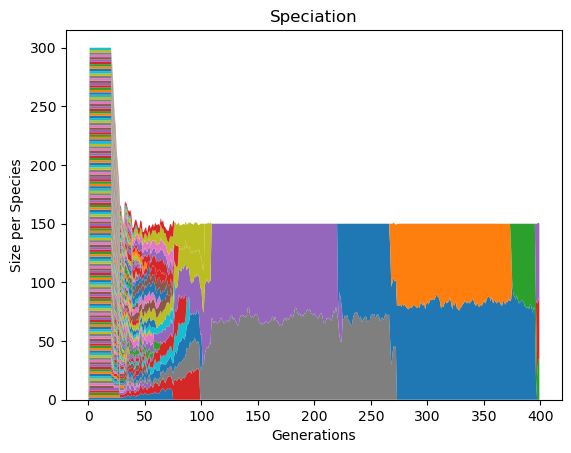

In [18]:

if __name__ == '__main__':
    
    x=run('config_TN_dh_holes')
    
    #Save the neural network in a pickle
    # Save the winning_neural_network to a file
    with open('my_winner.pkl', 'wb') as f:
        pickle.dump(x, f)


    

# Visualize the Best NN

In [19]:
# Load the object from the file
with open('my_winner.pkl', 'rb') as f:
    loaded_object = pickle.load(f)

    print(loaded_object)  # Output: 42

In [29]:
import random 
x_net = loaded_object
if __name__ == "__main__":
    # Create an instance of Tetris
    env = gym.make("tetris_gymnasium/Tetris", render_mode="human")
    rand_seed = random.randint(0,10000000)
    env.reset(seed = rand_seed)
    
    del_h_hist=0
    reward_hist=0
    start_clip =0
    # Main game loop
    terminated = False
    while not terminated:
        # Render the current state of the game as text
        env.render()
        ### CODE TO GET THE HEIGHT AFTER EACH FRAME 
            #the board doesn't include the piece (the piece is a projection onto the board)
        env1 = FeatureVectorObservation(env) #create an instance of the class

        height_i = env1.calc_height(env.board) #call a function from the class with the board as an input
        height_i = (height_i[4:14])-4 #crop out the padding on either side (the bedrock) and normalize by the 4 layers of bedrock underneath
        prev_height = height_i
        # Pick an action from user input mapped to the keyboard
        action = None
        while action is None:
            key = cv2.waitKey(1)
               
                        ### CODE TO GET THE HEIGHT AFTER EACH FRAME 
            #the board doesn't include the piece (the piece is a projection onto the board)
            env1 = FeatureVectorObservation(env) #create an instance of the class
            
            height_i = env1.calc_height(env.board) #call a function from the class with the board as an input
            height_i = (height_i[4:14])-4 #crop out the padding on either side (the bedrock) and normalize by the 4 layers of bedrock underneath
            #height_hist = np.vstack((height_hist,height_i)) #append to bottom of the historian

            ### Get the current tetromino in a list form and in the position relative to the other blocks
            tetromino = env.active_tetromino
            slices = env.get_tetromino_slices(tetromino, env.x, env.y)
            #Create pseudo_board of just zeros
            only_tetromino = np.zeros((24,18))
            #add the tetromino in its correct place
            only_tetromino[slices] += tetromino.matrix
            #Convert to 1s and 0s
            only_tetromino = np.where(only_tetromino > 0, 1, 0)
            #Sum in each column
            only_tetromino = np.sum(only_tetromino,axis=0)
            #Crop out the empty bedrock
            only_tetromino=only_tetromino[4:14]
            #print(only_tetromino)
            
            #compile the two features together
            i_feat = np.hstack((only_tetromino,height_i)) #this is a one dimensional list of 20 integers

            if start_clip==0:
                if key == ord("a"):
                    action = env.unwrapped.actions.move_left
                    start_clip=1
            else:
                action = np.argmax(x_net.activate(i_feat))
                if action ==2:
                    action = 5

            if (
                cv2.getWindowProperty(env.unwrapped.window_name, cv2.WND_PROP_VISIBLE)
                == 0
            ):
                sys.exit()
        time.sleep(.1) 
        # Perform the action
        observation, reward, terminated, truncated, info = env.step(action)
        reward_hist+=reward
        env1 = FeatureVectorObservation(env) #create an instance of the class
        #Calculate the change in max height only after a block is placed:
        if reward>0:
            height_new = env1.calc_height(env.board) #call a function from the class with the board as an input
            height_new = (height_new[4:14])-4
            #Find the difference in the height 
            max_h_index = np.argmax(height_new)
            i_del_h = height_new[max_h_index] - prev_height[max_h_index]

            #Assign height to previous height for the next step --> Didn't Work
            prev_height = height_new

            #Give positive reward if the height didn't change
            if i_del_h == 0:
                del_h_hist+=2
        #Calculate the holes after each frame --> Only need to return 
        holes_i = env1.calc_holes(env.board)
    # Game over
    print(rand_seed)
    print("Game Over!")
print(del_h_hist)

6252590
Game Over!
30


# Good Seeds:
2348894 --> 18
6252590 --> 30 !!! cleared two lines!!